# Identifying products categories

In [1]:
import pickle
import time
import sys
import os
import json
import folium
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import statsmodels.formula.api as sm

In [2]:
OPEN_FOOD_FACTS_PATH = 'data/en.openfoodfacts.org.products.csv'
ENCODING = 'UTF-8'

chunksize = 100000
tfr = pd.read_csv(OPEN_FOOD_FACTS_PATH, encoding=ENCODING, sep='\t', chunksize=chunksize, iterator=True, low_memory=False)
food_facts_df = pd.concat(tfr, ignore_index=True)
food_facts_df.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# List of fields providing information about the type of the product
names_fields = ['product_name','generic_name','brands_tags','categories','categories_tags','categories_en','labels','labels_tags','labels_en']

In [7]:
def get_field_without_nan(df:pd.DataFrame, field='origins'):
    '''
    Returns a Series of none nan values for the specified "field".
    Specifiy the length of the Series to return with "head". 
    :param df: dataframe to extract info from
    :param field: field of the database to evaluate
    :return: Series, containing all none nan values. 
    '''
    return df[field].dropna()

def get_fields_completeness(df:pd.DataFrame, fields:list, verbose=False):
    '''
    Create a barh plot of the levels of non nan values per field. 
    :param df: dataframe to extract info from
    :param fields: fields of the database to evaluate
    :param verbose: show progress
    :return: dict, completeness of each field
    '''
    fields_fill_percentage = {}
    total_number=len(df)
    for i,field in enumerate(fields):
        fields_fill_percentage[field] = len(get_field_without_nan(df,field))/total_number
        if verbose:
            print('Done [%d/%d]' % (i+1,len(fields)), end='\r')
    return fields_fill_percentage

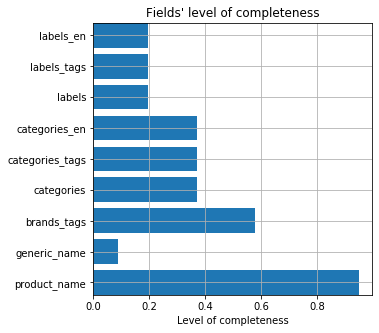

In [10]:
names_fill_percentage = get_fields_completeness(food_facts_df,names_fields,verbose=True)

plt.figure(figsize=(5,5))
plt.barh(list(names_fill_percentage.keys()),list(names_fill_percentage.values()))
plt.title('Fields\' level of completeness')
plt.xlabel('Level of completeness')
plt.margins(y=0)
plt.grid()

In [11]:
food_facts_df['product_name'].unique()

array(['Vitória crackers', 'Cacao', 'Filetes de pollo empanado', ...,
       'Tifkffhjk', 'Minis beignets',
       'Sandwich club Rillette poisson combava'], dtype=object)

In [15]:
print(len(food_facts_df['categories_en'].dropna()),'/',len(food_facts_df))
food_facts_df['categories_en'].unique()

389924 / 1051145


array([nan, 'Groceries,Condiments,Sauces,Mustards', 'fr:xsf', ...,
       'Plant-based foods and beverages,Plant-based foods,Breakfasts,Cereals and potatoes,Cereals and their products,Breakfast cereals,Tests,fr:tests',
       'Beverages,Alcoholic beverages,Hard liquors,fr:Eaux-de-vie,Vodka,Lettische vodkas,Tests,fr:tests',
       'hu:extrudált-kukorica'], dtype=object)

In [16]:
food_facts_df['categories'].unique()

array([nan, 'Epicerie,Condiments,Sauces,Moutardes', 'fr:Xsf', ...,
       'Plant-based foods and beverages, Plant-based foods, Breakfasts, Cereals and potatoes, Cereals and their products, Breakfast cereals, fr:Tests, Tests',
       'Beverages, Alcoholic beverages, Hard liquors, fr:Eaux-de-vie, Vodka, Lettische vodkas, fr:Tests, Tests',
       'Extrudált Kukorica'], dtype=object)

-> The field `categories_en` should be a good choice. It seems more reliable than the other fields. 

## Analysis of vocabulary
Based on `'categories_en'` field.

In [181]:
# Get the relevant column from the dataset
categories_df = food_facts_df[['categories_en']].dropna().copy()

In [182]:
categories_df

,categories_en
3,"Groceries,Condiments,Sauces,Mustards"
4,fr:xsf
10,"Meals,Prepared vegetables,Grated carrots,Seaso..."
17,"Pies,Sweet pies,Coconut pies"
25,"Plant-based foods and beverages,Plant-based fo..."
...,...
1051136,"Desserts,Chocolate desserts,Chocolate mousses"
1051137,"Plant-based foods and beverages,Plant-based fo..."
1051139,fr:tests
1051141,"Snacks,Sweet snacks,Sweet Fritters"


**Warning:** the `fr:` tag is mixed with english key words... Example: `"Meats,Poultries,Chickens,fr:Aiguillettes de poulet"`. This is not adressed here. 

In [183]:
categories_fr_df = categories_df[categories_df['categories_en'].apply(lambda x : 'fr:' in x)]
categories_fr_df.loc[27].values

array(['Meats,Poultries,Chickens,fr:Aiguillettes de poulet'], dtype=object)

Define some clean up methods (adapted from HM1):

In [186]:
from string import punctuation
stopwords_list = open('data/stopwords.txt', 'r').readlines()
stopwords_list = [x.strip() for x in stopwords_list]
def stopword_remover(text):
    text_list = re.findall(r"[\w']+", text) #text.split()
    text_list = [x for x in text_list if x not in stopwords_list]
    return ' '.join(text_list)
def lowercase_all(text):
    return text.lower()
def remove_punct(text):
    return ''.join([ch if ch not in punctuation else ' ' for ch in text])
def clean_text(text):
    return str(list(set(stopword_remover(lowercase_all(remove_punct(text))).split()))) # Remove duplicates

In [187]:
categories_df['categories_en'] = categories_df['categories_en'].apply(lambda x: clean_text(x))

Cleaned up categories without any duplicate: 

In [188]:
categories_df

,categories_en
3,"['sauces', 'condiments', 'mustards', 'groceries']"
4,"['fr', 'xsf']"
10,"['vegetables', 'grated', 'meals', 'prepared', ..."
17,"['pies', 'coconut', 'sweet']"
25,"['vegetables', 'desserts', 'fr', 'poire', 'com..."
...,...
1051136,"['chocolate', 'desserts', 'mousses']"
1051137,"['aromatic', 'cereals', 'products', 'rices', '..."
1051139,"['fr', 'tests']"
1051141,"['snacks', 'fritters', 'sweet']"


Use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to build a bag of words. The goal is to identify most common words describing the categories of products across the dataset. 

In [189]:
from sklearn.feature_extraction.text import CountVectorizer

In [190]:
vectorizer = CountVectorizer()
bag = vectorizer.fit_transform(categories_df['categories_en'].values)
bag_features = vectorizer.get_feature_names()
print('{} different words in total.'.format(len(bag_features)))

14164 different words in total.


In [191]:
print('Bag of words:\n',bag[0:2])
print('Corresponding features:\n',bag_features[0:4])

Bag of words:
   (0, 10258)	1
  (0, 2961)	1
  (0, 7833)	1
  (0, 5392)	1
  (1, 4616)	1
  (1, 12324)	1
Corresponding features:
 ['00', '0003', '001', '002']


In [192]:
# Sum along the columns to get the total number of occurencies of each token
words_occurences = np.array(bag.sum(axis=0))[0]

In [193]:
# Build a dataframe with the words occurencies
words_occurencies_df = pd.DataFrame({'word':bag_features,'count':words_occurences}).sort_values(by=['count'],ascending=False)\
                            .reset_index().drop(columns='index')

In [194]:
words_occurencies_df.head(10)

,word,count
0,foods,169601
1,beverages,148328
2,based,124466
3,plant,116745
4,products,100137
5,fr,74832
6,sweet,61965
7,snacks,57191
8,dairies,42992
9,alcoholic,42406


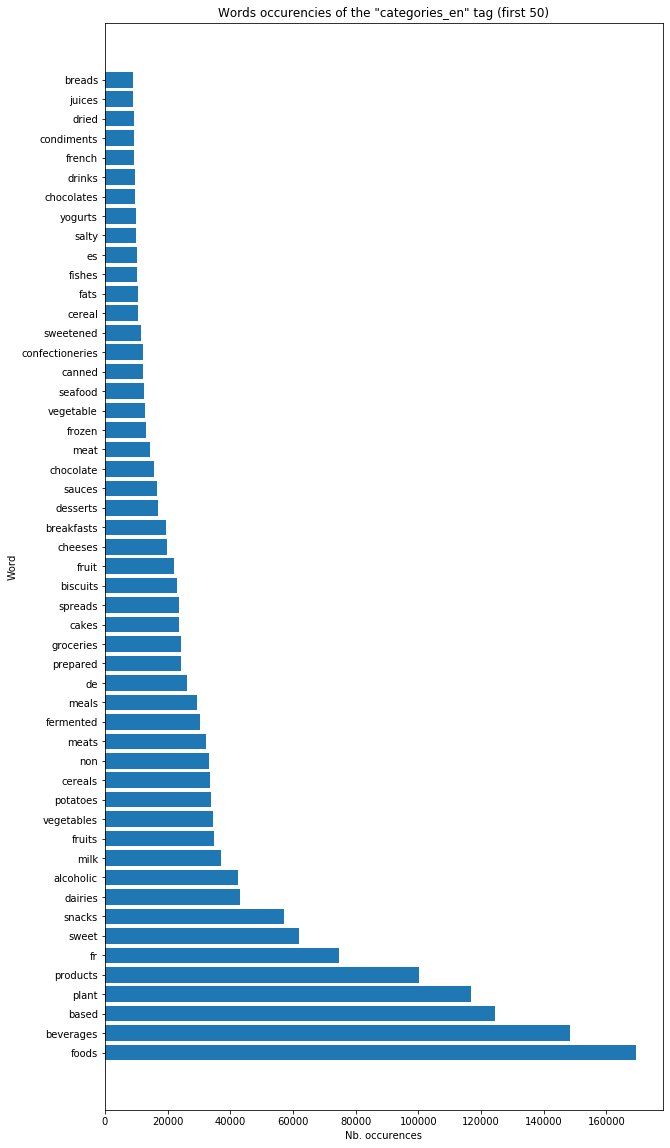

In [204]:
n = 50
plt.figure(figsize=(10,20))
plt.barh(words_occurencies_df.loc[0:n]['word'].values,words_occurencies_df.loc[0:n]['count'].values)
plt.title('Words occurencies of the "categories_en" tag (first {})'.format(n))
plt.ylabel('Word')
plt.xlabel('Nb. occurences')
plt.show()

The products could be selected and grouped based on their type, following the food pyramid:

<img src="Food_pyramid.gif">

This should enable an analysis per class with comparable products. For instance, **group the dairy products**:

In [200]:
# Clean up the dataset `categories_en` column
food_facts_df['categories_en'] = food_facts_df['categories_en'].apply(lambda x: clean_text(str(x)))

In [201]:
# Pick some keyword from the frequent words (see previous barh)
dairy_kw = ['dairies','milk','cheeses','cheese']
dairy_df = food_facts_df[food_facts_df['categories_en'].apply(lambda x : any(kw in x for kw in dairy_kw))]

This yields the following dataframe **containing only dairy products**:

In [202]:
dairy_df

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
51,0000000005005,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1521663684,2018-03-21T20:21:24Z,1545934272,2018-12-27T18:11:12Z,Abondance,NaN,NaN,...,NaN,14.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,0000000491228,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1543690964,2018-12-01T19:02:44Z,1543692731,2018-12-01T19:32:11Z,Entremets Crème Brulée,NaN,20 g,...,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,0000405017511,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1551706268,2019-03-04T13:31:08Z,1552159083,2019-03-09T19:18:03Z,Chaource lait cru,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,0000939333330,http://world-en.openfoodfacts.org/product/0000...,emoups,1569696676,2019-09-28T18:51:16Z,1569697074,2019-09-28T18:57:54Z,creme fraiche,NaN,"213g, 7.5OZ",...,NaN,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,00011747,http://world-en.openfoodfacts.org/product/0001...,teolemon,1424634361,2015-02-22T19:46:01Z,1561464979,2019-06-25T12:16:19Z,Triple Belgian Chocolaté Chunk Cookies,NaN,225 g e,...,NaN,23.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050907,99020118,http://world-en.openfoodfacts.org/product/9902...,openfoodfacts-contributors,1538391140,2018-10-01T10:52:20Z,1552150513,2019-03-09T16:55:13Z,pelardon,NaN,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1050963,99208653,http://world-en.openfoodfacts.org/product/9920...,hunsly,1544881898,2018-12-15T13:51:38Z,1571684749,2019-10-21T19:05:49Z,UHT lactozmentes tej,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1051021,9950050200503,http://world-en.openfoodfacts.org/product/9950...,kiliweb,1530118909,2018-06-27T17:01:49Z,1544862019,2018-12-15T08:20:19Z,Chocolat au lait,NaN,NaN,...,NaN,26.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1051050,997326239,http://world-en.openfoodfacts.org/product/9973...,openfoodfacts-contributors,1536926992,2018-09-14T12:09:52Z,1563526875,2019-07-19T09:01:15Z,Maroilles,NaN,210g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
